Utilizzo del dispositivo: cpu
Caricamento del modello CLIP (potrebbe richiedere del tempo la prima volta)...
✅ Modello CLIP caricato con successo.

Lettura dei dati dal file CSV: image_analysis_qwen_2x2_with_metadata_max_tokens_512.csv

Anteprima del DataFrame:
                                          Image Name  \
0         aleksey-savrasov_courtyard-spring-1853.jpg   
1                                                      
2                                                      
3                                                      
4                                                      
5  alfred-sisley_village-on-the-banks-of-the-sein...   
6                                                      
7                                                      
8                                                      
9                                                      

                        ArtworkTitle        ArtistName ArtworkYear Period  \
0                 Courtyard. Spring.  alekse

Analisi righe CSV: 100%|██████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 15106.44it/s]


✅ Trovati 100 file immagine (presunti) e 100 descrizioni allineate dopo il filtro.

Elenco completo dei file immagine estratti dal CSV (dopo il filtro e allineamento):
1. 'aleksey-savrasov_courtyard-spring-1853.jpg'
2. 'alfred-sisley_village-on-the-banks-of-the-seine-1872.jpg'
3. 'chaldin-alex_lilies.jpg'
4. 'currier-and-ives_catching-a-trout-1854.jpg'
5. 'edvard-munch_girl-yawning-1913.jpg'
6. 'edward-robert-hughes_day.jpg'
7. 'gerard-van-honthorst_diana-with-her-nymphs-1650.jpg'
8. 'giorgio-vasari_assumption-of-the-virgin-detail-1.jpg'
9. 'hans-andersen-brendekilde_en-skovtur-ved-odense-a-1897.jpg'
10. 'helene-de-beauvoir_untitled-9.jpg'
...



✅ Estratti 100 nomi di file immagine e 100 descrizioni totali pulite dal CSV.

=== Calcolo delle statistiche sulle descrizioni testuali (Descrizione 'Total') ===

Lunghezza massima delle descrizioni (parole): 430
Lunghezza minima delle descrizioni (parole): 273
Lunghezza media delle descrizioni (parole): 388.63
Numero di descrizioni > media: 66
Numero di descrizioni < media: 34
Numero di descrizioni = media: 0
Numero totale di descrizioni: 100
Descrizioni complete: 46
Descrizioni incomplete: 54
✅ Statistiche descrizioni salvate in 'description_statistics_TOTAL.csv'

Estrazione degli embeddings e calcolo delle similarità:


Elaborazione Coppie: 100%|███████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]



✅ Estratti con successo gli embeddings per 100 coppie.
✅ Calcolate 100 similarità immagine-testo.


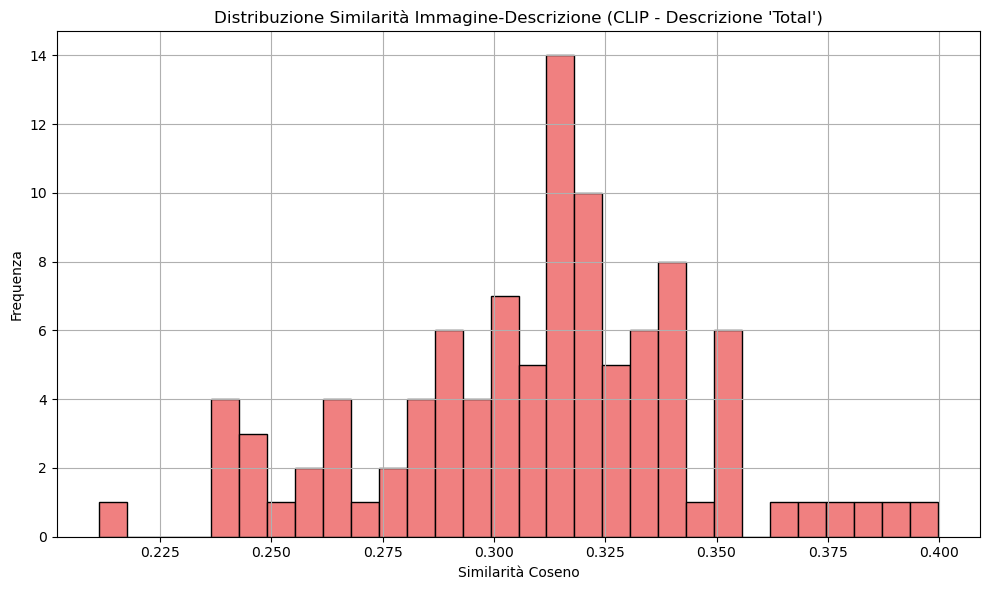


=== Statistiche Complessive Similarità Immagine-Descrizione (CLIP - Descrizione 'Total') ===
Numero di coppie elaborate: 100
Media: 0.3101
Mediana: 0.3149
Deviazione standard: 0.0356
Minima: 0.2113
Massima: 0.3998

✅ Statistiche complessive salvate in 'clip_similarity_statistics_TOTAL.csv'
✅ Similarità individuali salvate in 'clip_individual_similarities_TOTAL.csv'

=== 🔻 Peggiori match Immagine-Descrizione (Descrizione 'Total') ===
File: theophile-steinlen_ton-nez-1.jpg, Similarità: 0.2113
Descrizione: 'The artwork titled "Ton Nez" by Theophile Steinlen is a classic example of the Realist genre, characterized by its attention to detail, lifelike representation, and an emphasis on capturing the essenc...'

File: victor-hugo_the-cellist-1856.jpg, Similarità: 0.2371
Descrizione: 'The image you've provided is a fragment from Victor Hugo's 1856 artwork "The Cellist," which belongs to the genre of abstract art and aligns with the Romanticism movement, as well as the later Abstrac...'

File

In [4]:
import os
import pandas as pd
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import traceback
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize # sent_tokenize è ancora importato ma non usato nella funzione statistiche
import csv

# --- IMPORT CLIP ---
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# --- Scarica le risorse NLTK (eseguirà solo se le risorse non sono già presenti) ---
try:
    nltk.data.find('corpora/stopwords')
except:
    print("Download NLTK stopwords...")
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except:
    print("Download NLTK punkt tokenizer...")
    nltk.download('punkt')

# --- 1. Configurazione Iniziale ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizzo del dispositivo: {device}")

# Percorsi - Adatta questi percorsi alla tua struttura di directory su Jupyter/Colab
PATHS = {
    "csv_file": "image_analysis_qwen_2x2_with_metadata_max_tokens_512.csv", # Il tuo CSV con i metadati delle immagini
    "image_files_folder": "images100", # La cartella contenente i file immagine
    "output_statistics_csv": "clip_similarity_statistics_TOTAL.csv",
    "output_individual_similarities_csv": "clip_individual_similarities_TOTAL.csv",
    "output_description_statistics_TOTAL_csv": "description_statistics_TOTAL.csv" # Nuovo percorso per le statistiche delle descrizioni
}

# --- 2. Caricamento Modello CLIP ---
try:
    print("Caricamento del modello CLIP (potrebbe richiedere del tempo la prima volta)...")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print("✅ Modello CLIP caricato con successo.")
except Exception as e:
    print(f"❌ Errore durante il caricamento del modello CLIP: {e}")
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)

def read_image_data_from_csv(csv_path):
    """
    Legge il file CSV e estrae i nomi dei file immagine e le descrizioni totali.
    Si aspetta che i nomi delle immagini non inizino con 'Fragment' e cerca
    la riga con 'Total' nella colonna 'Description Type' (presumendo un offset).
    """
    final_image_filenames = []
    final_descriptions = []
    
    try:
        df = pd.read_csv(csv_path, keep_default_na=False)
        
        print("\nAnteprima del DataFrame:")
        print(df.head(10))

        print("\nColonne disponibili:")
        print(df.columns.tolist())
        
        possible_image_columns = ['Image Name', 'ArtworkTitle', 'ArtistName']
        image_col = None
        for col in possible_image_columns:
            if col in df.columns:
                image_col = col
                break
            
        if image_col is None:
            print("❌ Nessuna colonna con i nomi dei file immagine trovata tra le possibili opzioni.")
            return [], []

        description_type_col = "Description Type"
        description_col = "Description"

        if description_type_col not in df.columns or description_col not in df.columns:
             print(f"❌ Il CSV non contiene le colonne essenziali '{description_type_col}' e '{description_col}'.")
             return [], []

        print("\nInizio la ricerca di nomi file immagine e descrizioni allineate...")
        for idx in tqdm(df.index, desc="Analisi righe CSV"):
            current_filename_raw = str(df.loc[idx, image_col]).strip().replace('"', '')
            
            if not current_filename_raw or current_filename_raw.lower() == 'nan' or \
               current_filename_raw.lower().startswith('fragment'):
                continue

            image_name_base = current_filename_raw

            description_row_idx = idx + 4 

            if description_row_idx >= len(df):
                continue

            description_type_candidate = str(df.loc[description_row_idx, description_type_col]).strip()

            if description_type_candidate.lower() == 'total':
                actual_description = str(df.loc[description_row_idx, description_col]).strip()
                
                if actual_description:
                    final_image_filenames.append(image_name_base)
                    final_descriptions.append(actual_description)

        print(f"\n✅ Trovati {len(final_image_filenames)} file immagine (presunti) e {len(final_descriptions)} descrizioni allineate dopo il filtro.")
        
    except Exception as e:
        print(f"❌ Errore nella lettura o nel filtro del CSV: {e}")
        traceback.print_exc(file=sys.stdout)
        return [], []
        
    return final_image_filenames, final_descriptions

# --- Funzione di pulizia del testo per embeddings (non per statistiche) ---
def clean_description_text(text):
    """
    Rimuove parole e frasi indesiderate dalla descrizione, normalizza e rimuove stop words.
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    phrases_to_remove = [] 
    phrases_to_remove.sort(key=len, reverse=True)

    for phrase in phrases_to_remove:
        text = text.replace(phrase, " ")

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])

    words = word_tokenize(text, language='english')
    stop_words_english = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.strip() and word not in stop_words_english]
    
    text = " ".join(filtered_words)
    text = " ".join(text.split()).strip()
    
    if text:
        text = text[0].upper() + text[1:]

    return text

# --- FUNZIONE AGGIORNATA PER CALCOLARE LE STATISTICHE SULLE DESCRIZIONI TESTUALI ---
def calculate_description_statistics(descriptions: list, output_csv_path: str):
    """
    Calcola e salva le statistiche sulla lunghezza (in parole) e completezza delle descrizioni.
    Ogni descrizione è trattata come una singola unità per il conteggio.
    """
    print("\n=== Calcolo delle statistiche sulle descrizioni testuali (Descrizione 'Total') ===")
    
    all_description_lengths = []
    complete_descriptions_count = 0
    incomplete_descriptions_count = 0
    
    for description in descriptions:
        if not isinstance(description, str) or not description.strip():
            continue
        
        # Pulizia per il conteggio delle parole
        temp_text_for_length = description.lower()
        temp_text_for_length = temp_text_for_length.translate(str.maketrans('', '', string.punctuation))
        temp_text_for_length = ''.join([i for i in temp_text_for_length if not i.isdigit()])
        
        words = word_tokenize(temp_text_for_length, language='english')
        words = [word for word in words if word.strip()]
        
        description_length = len(words)
        
        if description_length > 0:
            all_description_lengths.append(description_length)
            
            # Valuta la completezza basandoti sull'ultimo carattere della descrizione ORIGINALE
            # (dopo aver rimosso eventuali spazi bianchi finali)
            stripped_description = description.strip()
            if stripped_description and (stripped_description.endswith('.') or 
                                         stripped_description.endswith('!') or 
                                         stripped_description.endswith('?')):
                complete_descriptions_count += 1
            else:
                incomplete_descriptions_count += 1
    
    if not all_description_lengths:
        print("Nessuna descrizione valida trovata per il calcolo delle statistiche.")
        try:
            with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Status', 'No valid descriptions found'])
            print(f"Statistiche descrizioni salvate in '{output_csv_path}' (nessuna descrizione valida).")
        except Exception as e:
            print(f"ERRORE nel salvare le statistiche delle descrizioni: {e}")
        return

    max_len = np.max(all_description_lengths)
    min_len = np.min(all_description_lengths)
    mean_len = np.mean(all_description_lengths)
    
    above_mean = sum(1 for length in all_description_lengths if length > mean_len)
    below_mean = sum(1 for length in all_description_lengths if length < mean_len)
    equal_mean = sum(1 for length in all_description_lengths if length == mean_len)
    
    total_descriptions_count = len(all_description_lengths)

    print(f"\nLunghezza massima delle descrizioni (parole): {max_len}")
    print(f"Lunghezza minima delle descrizioni (parole): {min_len}")
    print(f"Lunghezza media delle descrizioni (parole): {mean_len:.2f}")
    print(f"Numero di descrizioni > media: {above_mean}")
    print(f"Numero di descrizioni < media: {below_mean}")
    print(f"Numero di descrizioni = media: {equal_mean}")
    print(f"Numero totale di descrizioni: {total_descriptions_count}")
    print(f"Descrizioni complete: {complete_descriptions_count}")
    print(f"Descrizioni incomplete: {incomplete_descriptions_count}")
    
    try:
        with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Metric', 'Value'])
            writer.writerow(['Max Description Length (Words)', max_len])
            writer.writerow(['Min Description Length (Words)', min_len])
            writer.writerow(['Mean Description Length (Words)', f"{mean_len:.2f}"])
            writer.writerow(['Descriptions > Mean Length', above_mean])
            writer.writerow(['Descriptions < Mean Length', below_mean])
            writer.writerow(['Descriptions = Mean Length', equal_mean])
            writer.writerow(['Total Descriptions Count', total_descriptions_count])
            writer.writerow(['Complete Descriptions', complete_descriptions_count])
            writer.writerow(['Incomplete Descriptions', incomplete_descriptions_count])
        print(f"✅ Statistiche descrizioni salvate in '{output_csv_path}'")
    except Exception as e:
        print(f"❌ ERRORE nel salvare le statistiche delle descrizioni: {e}")


# --- 4. Caricamento Dati dal CSV ---
print(f"\nLettura dei dati dal file CSV: {PATHS['csv_file']}")
image_filenames, total_descriptions = read_image_data_from_csv(PATHS["csv_file"])

if not image_filenames:
    print("❌ Errore: Nessun nome di file immagine valido e nessuna descrizione totale estratta dal CSV dopo il filtro.")
    sys.exit(1)

print("\nElenco completo dei file immagine estratti dal CSV (dopo il filtro e allineamento):")
for i, filename in enumerate(image_filenames):
    if i < 10:
        print(f"{i+1}. '{filename}'")
    elif i == 10:
        print("...")

descriptions_cleaned = [clean_description_text(desc) for desc in total_descriptions]

print(f"\n✅ Estratti {len(image_filenames)} nomi di file immagine e {len(descriptions_cleaned)} descrizioni totali pulite dal CSV.")

# --- Calcola e salva le statistiche sulle descrizioni TOTALI ---
calculate_description_statistics(total_descriptions, PATHS["output_description_statistics_TOTAL_csv"])


# --- 5. Estrazione Embeddings Immagine e Testo per ogni coppia ---
image_embeddings_list = []
text_embeddings_list = []
processed_pairs_info = []

print("\nEstrazione degli embeddings e calcolo delle similarità:")
for i in tqdm(range(len(image_filenames)), desc="Elaborazione Coppie"):
    filename = image_filenames[i]
    description_for_embedding = descriptions_cleaned[i]
    description_original = total_descriptions[i]
    
    MAX_TEXT_CHAR_LENGTH = 512
    if isinstance(description_for_embedding, str) and len(description_for_embedding) > MAX_TEXT_CHAR_LENGTH:
        truncated_description = description_for_embedding[:MAX_TEXT_CHAR_LENGTH]
        if not truncated_description.endswith('...'):
            truncated_description += "..."
    else:
        truncated_description = description_for_embedding

    if not filename or str(filename).strip().lower() == 'nan':
        continue

    full_image_path = None
    base_name, _ = os.path.splitext(filename)
    extensions_to_try = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
    
    found_image = False
    for ext in extensions_to_try:
        attempt_path = os.path.join(PATHS["image_files_folder"], base_name + ext)
        if os.path.isfile(attempt_path):
            full_image_path = attempt_path
            found_image = True
            break
            
    if not found_image:
        print(f"❌ Impossibile trovare un file immagine per '{filename}' con estensioni comuni nel percorso specificato.")
        continue
    
    if not truncated_description.strip():
        print(f"⚠️ Saltato '{filename}': La descrizione è diventata vuota dopo la pulizia.")
        continue

    try:
        image = Image.open(full_image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)
        
        inputs = clip_processor(text=[truncated_description], return_tensors="pt", padding=True, truncation=True).to(device)
        text_features = clip_model.get_text_features(input_ids=inputs.input_ids)

        image_embeddings_list.append(image_features.cpu().detach())
        text_embeddings_list.append(text_features.cpu().detach())
        processed_pairs_info.append({
            'filename': os.path.basename(full_image_path),
            'description': description_original
        })

    except Exception as e:
        print(f"❌ ERRORE durante l'elaborazione di '{filename}': {str(e)}")
        continue

if not image_embeddings_list:
    print("\n❌ Errore: Nessuna coppia immagine-testo è stata elaborata con successo.")
    sys.exit(1)

image_embeddings_tensor = torch.vstack(image_embeddings_list)
text_embeddings_tensor = torch.vstack(text_embeddings_list)

print(f"\n✅ Estratti con successo gli embeddings per {len(image_embeddings_tensor)} coppie.")

# --- 6. Calcolo Similarità Coseno ---
image_embeddings_norm = torch.nn.functional.normalize(image_embeddings_tensor, p=2, dim=-1)
text_embeddings_norm = torch.nn.functional.normalize(text_embeddings_tensor, p=2, dim=-1)

similarities = (image_embeddings_norm * text_embeddings_norm).sum(dim=-1)
similarities_np = similarities.cpu().detach().numpy()

print(f"✅ Calcolate {len(similarities_np)} similarità immagine-testo.")

# --- 7. Visualizzazione Distribuzione Similarità ---
plt.figure(figsize=(10, 6))
plt.hist(similarities_np, bins=30, color='lightcoral', edgecolor='black')
plt.title("Distribuzione Similarità Immagine-Descrizione (CLIP - Descrizione 'Total')")
plt.xlabel("Similarità Coseno")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Statistiche Complessive ---
print("\n=== Statistiche Complessive Similarità Immagine-Descrizione (CLIP - Descrizione 'Total') ===")
num_pairs = len(similarities_np)
mean_sim = np.mean(similarities_np)
median_sim = np.median(similarities_np)
std_sim = np.std(similarities_np)
min_sim = np.min(similarities_np)
max_sim = np.max(similarities_np)

print(f"Numero di coppie elaborate: {num_pairs}")
print(f"Media: {mean_sim:.4f}")
print(f"Mediana: {median_sim:.4f}")
print(f"Deviazione standard: {std_sim:.4f}")
print(f"Minima: {min_sim:.4f}")
print(f"Massima: {max_sim:.4f}")

# --- 9. Salvataggio Statistiche Complessive su CSV ---
try:
    stats_df = pd.DataFrame({
        'Metrica': ['Numero di Coppie', 'Media', 'Mediana', 'Deviazione Standard', 'Minima', 'Massima'],
        'Valore': [num_pairs, mean_sim, median_sim, std_sim, min_sim, max_sim]
    })
    stats_df.to_csv(PATHS["output_statistics_csv"], index=False)
    print(f"\n✅ Statistiche complessive salvate in '{PATHS['output_statistics_csv']}'")
except Exception as e:
    print(f"❌ Errore durante il salvataggio delle statistiche: {e}")
    traceback.print_exc(file=sys.stdout)

# --- 10. Salvataggio Similarità Individuali ---
if processed_pairs_info:
    individual_similarities_data = []
    for idx, pair_info in enumerate(processed_pairs_info):
        individual_similarities_data.append({
            'Filename Immagine': pair_info['filename'],
            'Descrizione Originale (Total)': pair_info['description'],
            'Similarita Coseno': similarities_np[idx]
        })
    
    try:
        individual_sim_df = pd.DataFrame(individual_similarities_data)
        individual_sim_df.to_csv(PATHS["output_individual_similarities_csv"], index=False)
        print(f"✅ Similarità individuali salvate in '{PATHS['output_individual_similarities_csv']}'")
    except Exception as e:
        print(f"❌ Errore durante il salvataggio delle similarità individuali: {e}")
        traceback.print_exc(file=sys.stdout)
else:
    print("\n⚠️ Nessuna coppia immagine-testo elaborata.")

# --- 11. Visualizza Esempi Migliori e Peggiori ---
def print_similarity_examples(indices, title, data_info, similarities_scores, num_examples=5):
    print(f"\n=== {title} ===")
    for i, idx in enumerate(indices):
        if i >= num_examples:
            break
        filename = data_info[idx]['filename']
        description = data_info[idx]['description']
        sim_score = similarities_scores[idx]
        print(f"File: {filename}, Similarità: {sim_score:.4f}")
        print(f"Descrizione: '{description[:200]}...'\n")

sorted_indices = np.argsort(similarities_np)

print_similarity_examples(sorted_indices[:5], "🔻 Peggiori match Immagine-Descrizione (Descrizione 'Total')", processed_pairs_info, similarities_np)
print_similarity_examples(sorted_indices[-5:][::-1], "🔺 Migliori match Immagine-Descrizione (Descrizione 'Total')", processed_pairs_info, similarities_np)

print("\nProcesso di analisi CLIP (Descrizione 'Total') completato.")

Utilizzo del dispositivo: cpu
Caricamento del modello CLIP (potrebbe richiedere del tempo la prima volta)...
✅ Modello CLIP caricato con successo.

Lettura dei dati dal file CSV: image_analysis_qwen_2x2_with_metadata_max_tokens_512.csv

Anteprima del DataFrame (per debug):
                                          Image Name  \
0         aleksey-savrasov_courtyard-spring-1853.jpg   
1                                                      
2                                                      
3                                                      
4                                                      
5  alfred-sisley_village-on-the-banks-of-the-sein...   
6                                                      
7                                                      
8                                                      
9                                                      

                        ArtworkTitle        ArtistName ArtworkYear Period  \
0                 Courtyard. Spr

Scansione righe CSV (Somma Fragment): 100%|████████████████████████████████████████| 500/500 [00:00<00:00, 7143.55it/s]


✅ Trovati 100 file immagine e 100 descrizioni combinate dai frammenti dopo il filtro.

--- Prime 5 coppie finali restituite da read_image_data_from_csv_fragment_sum ---
File [0]: 'aleksey-savrasov_courtyard-spring-1853.jpg'
Descrizione [0]: 'This fragment of the artwork "Courtyard. Spring" by Aleksey Savrasov, created in 1853, captures a se...'
File [1]: 'alfred-sisley_village-on-the-banks-of-the-seine-1872.jpg'
Descrizione [1]: 'This image fragment, taken from Alfred Sisley's painting "Village on the Banks of the Seine," showca...'
File [2]: 'chaldin-alex_lilies.jpg'
Descrizione [2]: 'This fragment of the artwork "Lilies" by Chaldin-Alex showcases a vibrant and dynamic composition, c...'
File [3]: 'currier-and-ives_catching-a-trout-1854.jpg'
Descrizione [3]: 'This fragment from "Catching a Trout" (1854) by Currier & Ives showcases two individuals in a rural,...'
File [4]: 'edvard-munch_girl-yawning-1913.jpg'
Descrizione [4]: 'This fragment of the artwork "Girl Yawning" by Edvard Munc


✅ Estratti 100 nomi di file immagine e 100 descrizioni combinate pulite dal CSV.

=== Calcolo delle statistiche sulle descrizioni testuali (Somma Fragment) ===

Lunghezza massima delle descrizioni (parole): 816
Lunghezza minima delle descrizioni (parole): 369
Lunghezza media delle descrizioni (parole): 492.87
Numero di descrizioni > media: 36
Numero di descrizioni < media: 64
Numero di descrizioni = media: 0
Numero totale di descrizioni: 100
Descrizioni complete: 100
Descrizioni incomplete: 0
✅ Statistiche descrizioni salvate in 'description_statistics_FRAGMENT_SUM.csv'

Estrazione degli embeddings e calcolo delle similarità:


Elaborazione Coppie Immagine-Testo (Somma Fragment): 100%|███████████████████████████| 100/100 [00:27<00:00,  3.63it/s]



✅ Estratti con successo gli embeddings per 100 coppie.
✅ Calcolate 100 similarità immagine-testo.


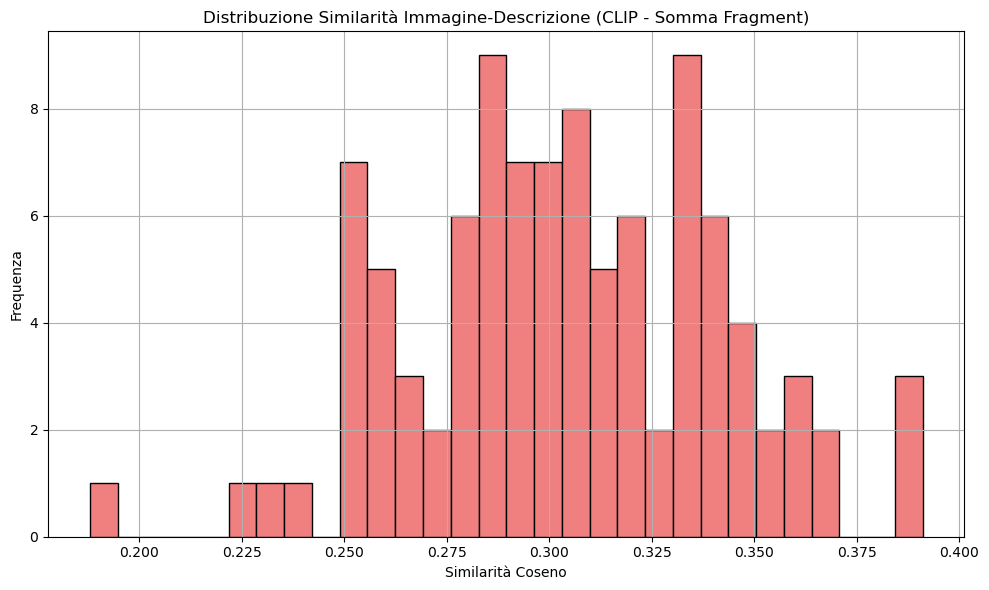


=== Statistiche Complessive Similarità Immagine-Descrizione (CLIP - Somma Fragment) ===
Numero di coppie elaborate: 100
Media: 0.3039
Mediana: 0.3017
Deviazione standard: 0.0379
Minima: 0.1879
Massima: 0.3911

✅ Statistiche complessive salvate in 'clip_similarity_statistics_fragment_sum.csv'
✅ Similarità individuali salvate in 'clip_individual_similarities_fragment_sum.csv'

=== 🔻 Peggiori match Immagine-Descrizione (Somma Fragment) ===
File: pierre-tal-coat_self-portrait.jpg, Similarità: 0.1879
Descrizione (Combinata Frammenti): 'This fragment of the artwork "Self-Portrait" by Pierre-Tal-Coat showcases a highly abstracted face in grayscale, characteristic of the Tachisme movement. The face is rendered with expressive, gestural...'

File: richard-jack_the-honourable-edith-violet-kathleen-agar-robartes.jpg, Similarità: 0.2228
Descrizione (Combinata Frammenti): 'The image depicts a small portion of a portrait in the style of impressionism, belonging to the genre of portraiture. The frag

In [5]:
import os
import pandas as pd
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import traceback
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize # sent_tokenize è ancora importato ma non usato nella funzione statistiche
import csv

# --- IMPORT CLIP ---
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# --- Scarica le risorse NLTK (eseguirà solo se le risorse non sono già presenti) ---
try:
    nltk.data.find('corpora/stopwords')
except:
    print("Download NLTK stopwords...")
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except:
    print("Download NLTK punkt tokenizer...")
    nltk.download('punkt')

# --- 1. Configurazione Iniziale ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizzo del dispositivo: {device}")

# Percorsi - ADATTA QUESTI PERCORSI AL TUO AMBIENTE KAGGLE/JUPYTER
PATHS = {
    "csv_file": "image_analysis_qwen_2x2_with_metadata_max_tokens_512.csv", # Il tuo CSV
    "image_files_folder": "./images100", # La cartella delle tue immagini
    "output_statistics_csv": "clip_similarity_statistics_fragment_sum.csv",
    "output_individual_similarities_csv": "clip_individual_similarities_fragment_sum.csv",
    "output_description_statistics_FRAGMENT_SUM_csv": "description_statistics_FRAGMENT_SUM.csv" # Nuovo percorso per le statistiche delle descrizioni dei frammenti sommati
}

# Impostazioni aggiuntive per la logica dei frammenti nel CSV
GRID_ROWS = 2
GRID_COLS = 2
TOTAL_GRID_SEGMENTS = GRID_ROWS * GRID_COLS # Dovrebbe essere 4 per 2x2

# --- 2. Caricamento Modello CLIP ---
try:
    print("Caricamento del modello CLIP (potrebbe richiedere del tempo la prima volta)...")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print("✅ Modello CLIP caricato con successo.")
except Exception as e:
    print(f"❌ Errore durante il caricamento del modello CLIP: {e}")
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)

# --- FUNZIONE CORRETTA PER LEGGERE I DATI DELLE IMMAGINI CON "SOMMA FRAGMENT" ---
def read_image_data_from_csv_fragment_sum(csv_path):
    """
    Legge il file CSV, identifica i nomi dei file immagine e costruisce una singola descrizione
    concatenando i testi dei "Fragment 1", "Fragment 2", ecc.
    Gestisce i campi vuoti in 'Image Name' per i frammenti, raggruppando i frammenti sotto l'immagine principale.
    """
    final_image_filenames = []
    final_descriptions = []
    
    try:
        df = pd.read_csv(csv_path, keep_default_na=False)
        
        print("\nAnteprima del DataFrame (per debug):")
        print(df.head(10))

        print("\nColonne disponibili (per debug):")
        print(df.columns.tolist())
        
        image_col = "Image Name" 
        description_type_col = "Description Type"
        description_col = "Description"

        if image_col not in df.columns or description_type_col not in df.columns or description_col not in df.columns:
             print(f"❌ Il CSV non contiene le colonne essenziali '{image_col}', '{description_type_col}', '{description_col}'.")
             return [], []

        print("\nInizio la raccolta delle descrizioni dai frammenti per le immagini...")
        
        current_image_name = None
        current_fragments = [] # Lista per tenere i frammenti del blocco corrente

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Scansione righe CSV (Somma Fragment)"):
            row_image_name = str(row[image_col]).strip()
            row_description_type = str(row[description_type_col]).strip().lower()
            row_description = str(row[description_col]).strip()

            if row_image_name and row_image_name.lower() != 'nan' and \
               not row_image_name.lower().startswith('fragment') and \
               not row_image_name.lower().startswith('total'):
                
                if current_image_name and current_fragments:
                    final_image_filenames.append(current_image_name)
                    final_descriptions.append(" ".join(current_fragments).strip())
                
                current_image_name = row_image_name
                current_fragments = []
            
            elif current_image_name and row_description_type.startswith('fragment '):
                try:
                    fragment_num = int(row_description_type.split(' ')[1])
                    if 1 <= fragment_num <= TOTAL_GRID_SEGMENTS:
                        if row_description:
                            current_fragments.append(row_description)
                except ValueError:
                    pass 
            
        if current_image_name and current_fragments:
            final_image_filenames.append(current_image_name)
            final_descriptions.append(" ".join(current_fragments).strip())

        print(f"\n✅ Trovati {len(final_image_filenames)} file immagine e {len(final_descriptions)} descrizioni combinate dai frammenti dopo il filtro.")
        
        print("\n--- Prime 5 coppie finali restituite da read_image_data_from_csv_fragment_sum ---")
        for j in range(min(5, len(final_image_filenames))):
            print(f"File [{j}]: '{final_image_filenames[j]}'")
            print(f"Descrizione [{j}]: '{final_descriptions[j][:100]}...'")
        print(f"Totale coppie processate: {len(final_image_filenames)}")
        print("--------------------------------------------------")

    except Exception as e:
        print(f"❌ Errore nella lettura o nel filtro del CSV: {e}")
        traceback.print_exc(file=sys.stdout)
        return [], []
        
    return final_image_filenames, final_descriptions

# --- Funzione di pulizia del testo per embeddings (non per statistiche) ---
def clean_description_text(text):
    """
    Rimuove parole e frasi indesiderate dalla descrizione, normalizza e rimuove stop words.
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    phrases_to_remove = [
        "this image depicts", "the image shows", "a visual representation of",
        "the painting illustrates", "the artwork portrays", "this image presents"
    ]
    phrases_to_remove.sort(key=len, reverse=True)

    for phrase in phrases_to_remove:
        text = text.replace(phrase, " ")

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])

    words = word_tokenize(text, language='english')
    stop_words_list = set(stopwords.words('english'))
    
    filtered_words = [word for word in words if word.strip() and word not in stop_words_list]
    
    text = " ".join(filtered_words)
    text = " ".join(text.split()).strip()
    
    if text:
        text = text[0].upper() + text[1:]
    else:
        text = ""

    return text

# --- FUNZIONE AGGIORNATA PER CALCOLARE LE STATISTICHE SULLE DESCRIZIONI TESTUALI ---
def calculate_description_statistics(descriptions: list, output_csv_path: str):
    """
    Calcola e salva le statistiche sulla lunghezza (in parole) e completezza delle descrizioni combinate dai frammenti.
    Ogni descrizione aggregata è trattata come una singola unità per il conteggio.
    """
    print("\n=== Calcolo delle statistiche sulle descrizioni testuali (Somma Fragment) ===")
    
    all_description_lengths = []
    complete_descriptions_count = 0
    incomplete_descriptions_count = 0
    
    for description in descriptions:
        if not isinstance(description, str) or not description.strip():
            continue
        
        # Pulizia per il conteggio delle parole
        temp_text_for_length = description.lower()
        phrases_to_remove = [
            "this image depicts", "the image shows", "a visual representation of",
            "the painting illustrates", "the artwork portrays", "this image presents"
        ]
        phrases_to_remove.sort(key=len, reverse=True)
        for phrase in phrases_to_remove:
            temp_text_for_length = temp_text_for_length.replace(phrase, " ")

        temp_text_for_length = temp_text_for_length.translate(str.maketrans('', '', string.punctuation))
        temp_text_for_length = ''.join([i for i in temp_text_for_length if not i.isdigit()])
        
        words = word_tokenize(temp_text_for_length, language='english')
        words = [word for word in words if word.strip()]
        
        description_length = len(words)
        
        if description_length > 0:
            all_description_lengths.append(description_length)

            # Valuta la completezza basandoti sull'ultimo carattere della descrizione ORIGINALE
            # (dopo aver rimosso eventuali spazi bianchi finali)
            stripped_description = description.strip()
            if stripped_description and (stripped_description.endswith('.') or 
                                         stripped_description.endswith('!') or 
                                         stripped_description.endswith('?')):
                complete_descriptions_count += 1
            else:
                incomplete_descriptions_count += 1
    
    if not all_description_lengths:
        print("Nessuna descrizione valida trovata per il calcolo delle statistiche.")
        try:
            with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Status', 'No valid descriptions found'])
            print(f"Statistiche descrizioni salvate in '{output_csv_path}' (nessuna descrizione valida).")
        except Exception as e:
            print(f"ERRORE nel salvare le statistiche delle descrizioni: {e}")
        return

    max_len = np.max(all_description_lengths)
    min_len = np.min(all_description_lengths)
    mean_len = np.mean(all_description_lengths)
    
    above_mean = sum(1 for length in all_description_lengths if length > mean_len)
    below_mean = sum(1 for length in all_description_lengths if length < mean_len)
    equal_mean = sum(1 for length in all_description_lengths if length == mean_len)
    
    total_descriptions_count = len(all_description_lengths)

    print(f"\nLunghezza massima delle descrizioni (parole): {max_len}")
    print(f"Lunghezza minima delle descrizioni (parole): {min_len}")
    print(f"Lunghezza media delle descrizioni (parole): {mean_len:.2f}")
    print(f"Numero di descrizioni > media: {above_mean}")
    print(f"Numero di descrizioni < media: {below_mean}")
    print(f"Numero di descrizioni = media: {equal_mean}")
    print(f"Numero totale di descrizioni: {total_descriptions_count}")
    print(f"Descrizioni complete: {complete_descriptions_count}")
    print(f"Descrizioni incomplete: {incomplete_descriptions_count}")
    
    try:
        with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Metric', 'Value'])
            writer.writerow(['Max Description Length (Words)', max_len])
            writer.writerow(['Min Description Length (Words)', min_len])
            writer.writerow(['Mean Description Length (Words)', f"{mean_len:.2f}"])
            writer.writerow(['Descriptions > Mean Length', above_mean])
            writer.writerow(['Descriptions < Mean Length', below_mean])
            writer.writerow(['Descriptions = Mean Length', equal_mean])
            writer.writerow(['Total Descriptions Count', total_descriptions_count])
            writer.writerow(['Complete Descriptions', complete_descriptions_count])
            writer.writerow(['Incomplete Descriptions', incomplete_descriptions_count])
        print(f"✅ Statistiche descrizioni salvate in '{output_csv_path}'")
    except Exception as e:
        print(f"❌ ERRORE nel salvare le statistiche delle descrizioni: {e}")


# --- 4. Caricamento Dati dal CSV ---
print(f"\nLettura dei dati dal file CSV: {PATHS['csv_file']}")
image_filenames, total_descriptions = read_image_data_from_csv_fragment_sum(PATHS["csv_file"])

if not image_filenames:
    print("❌ Errore: Nessun nome di file immagine valido e nessuna descrizione combinata estratta dal CSV dopo il filtro.")
    sys.exit(1)

print("\nElenco completo dei file immagine estratti dal CSV (dopo la combinazione dei frammenti):")
for i, filename in enumerate(image_filenames):
    if i < 10:
        print(f"{i+1}. '{filename}'")
    elif i == 10:
        print("...")

descriptions_cleaned = [clean_description_text(desc) for desc in total_descriptions]

print(f"\n✅ Estratti {len(image_filenames)} nomi di file immagine e {len(descriptions_cleaned)} descrizioni combinate pulite dal CSV.")

# --- Calcola e salva le statistiche sulle descrizioni dei FRAMMENTI SOMMATI ---
calculate_description_statistics(total_descriptions, PATHS["output_description_statistics_FRAGMENT_SUM_csv"])


# --- 5. Estrazione Embeddings Immagine e Testo per ogni coppia ---
image_embeddings_list = []
text_embeddings_list = []
processed_pairs_info = []

print("\nEstrazione degli embeddings e calcolo delle similarità:")
for i, filename_base in tqdm(enumerate(image_filenames), total=len(image_filenames), desc="Elaborazione Coppie Immagine-Testo (Somma Fragment)"):
    description_for_embedding = descriptions_cleaned[i]
    description_original = total_descriptions[i]
    
    MAX_TEXT_CHAR_LENGTH = 512
    if isinstance(description_for_embedding, str) and len(description_for_embedding) > MAX_TEXT_CHAR_LENGTH:
        truncated_description = description_for_embedding[:MAX_TEXT_CHAR_LENGTH]
        if not truncated_description.endswith(('.', '!', '?')) and len(description_for_embedding) > MAX_TEXT_CHAR_LENGTH:
            truncated_description += "..."
    else:
        truncated_description = description_for_embedding

    if not filename_base or str(filename_base).strip().lower() == 'nan':
        continue

    full_image_path = None
    base_name, _ = os.path.splitext(filename_base)
    extensions_to_try = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
    
    found_image = False
    for ext in extensions_to_try:
        attempt_path = os.path.join(PATHS["image_files_folder"], base_name + ext)
        if os.path.isfile(attempt_path):
            full_image_path = attempt_path
            found_image = True
            break
            
    if not found_image:
        print(f"❌ Impossibile trovare un file immagine per '{filename_base}' in '{PATHS['image_files_folder']}'. Saltando.")
        continue
    
    if not truncated_description.strip():
        print(f"❌ Descrizione vuota o solo spazi per '{filename_base}'. Saltando.")
        continue

    try:
        image = Image.open(full_image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)
        
        inputs = clip_processor(text=[truncated_description], return_tensors="pt", padding=True, truncation=True).to(device)
        text_features = clip_model.get_text_features(input_ids=inputs.input_ids)

        image_embeddings_list.append(image_features.cpu().detach())
        text_embeddings_list.append(text_features.cpu().detach())
        processed_pairs_info.append({
            'filename': os.path.basename(full_image_path),
            'description': description_original
        })

    except Exception as e:
        print(f"❌ ERRORE durante l'elaborazione di '{filename_base}': {str(e)}")
        continue

if not image_embeddings_list:
    print("\n❌ Errore: Nessuna coppia immagine-testo è stata elaborata con successo.")
    sys.exit(1)

image_embeddings_tensor = torch.vstack(image_embeddings_list)
text_embeddings_tensor = torch.vstack(text_embeddings_list)

print(f"\n✅ Estratti con successo gli embeddings per {len(image_embeddings_tensor)} coppie.")

# --- 6. Calcolo Similarità Coseno ---
image_embeddings_norm = torch.nn.functional.normalize(image_embeddings_tensor, p=2, dim=-1)
text_embeddings_norm = torch.nn.functional.normalize(text_embeddings_tensor, p=2, dim=-1)

similarities = (image_embeddings_norm * text_embeddings_norm).sum(dim=-1)
similarities_np = similarities.cpu().detach().numpy()

print(f"✅ Calcolate {len(similarities_np)} similarità immagine-testo.")

# --- 7. Visualizzazione Distribuzione Similarità ---
plt.figure(figsize=(10, 6))
plt.hist(similarities_np, bins=30, color='lightcoral', edgecolor='black')
plt.title("Distribuzione Similarità Immagine-Descrizione (CLIP - Somma Fragment)")
plt.xlabel("Similarità Coseno")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Statistiche Complessive ---
print("\n=== Statistiche Complessive Similarità Immagine-Descrizione (CLIP - Somma Fragment) ===")
num_pairs = len(similarities_np)
mean_sim = np.mean(similarities_np)
median_sim = np.median(similarities_np)
std_sim = np.std(similarities_np)
min_sim = np.min(similarities_np)
max_sim = np.max(similarities_np)

print(f"Numero di coppie elaborate: {num_pairs}")
print(f"Media: {mean_sim:.4f}")
print(f"Mediana: {median_sim:.4f}")
print(f"Deviazione standard: {std_sim:.4f}")
print(f"Minima: {min_sim:.4f}")
print(f"Massima: {max_sim:.4f}")

# --- 9. Salvataggio Statistiche Complessive su CSV ---
try:
    stats_df = pd.DataFrame({
        'Metrica': ['Numero di Coppie', 'Media', 'Mediana', 'Deviazione Standard', 'Minima', 'Massima'],
        'Valore': [num_pairs, mean_sim, median_sim, std_sim, min_sim, max_sim]
    })
    stats_df.to_csv(PATHS["output_statistics_csv"], index=False)
    print(f"\n✅ Statistiche complessive salvate in '{PATHS['output_statistics_csv']}'")
except Exception as e:
    print(f"❌ Errore durante il salvataggio delle statistiche: {e}")
    traceback.print_exc(file=sys.stdout)

# --- 10. Salvataggio Similarità Individuali ---
if processed_pairs_info:
    individual_similarities_data = []
    for idx, pair_info in enumerate(processed_pairs_info):
        individual_similarities_data.append({
            'Filename Immagine': pair_info['filename'],
            'Descrizione Originale (Combinata Frammenti)': pair_info['description'],
            'Similarita Coseno': similarities_np[idx]
        })
    
    try:
        individual_sim_df = pd.DataFrame(individual_similarities_data)
        individual_sim_df.to_csv(PATHS["output_individual_similarities_csv"], index=False)
        print(f"✅ Similarità individuali salvate in '{PATHS['output_individual_similarities_csv']}'")
    except Exception as e:
        print(f"❌ Errore durante il salvataggio delle similarità individuali: {e}")
        traceback.print_exc(file=sys.stdout)
else:
    print("\n⚠️ Nessuna coppia immagine-testo elaborata.")

# --- 11. Visualizza Esempi Migliori e Peggiori ---
def print_similarity_examples(indices, title, data_info, similarities_scores, num_examples=5):
    print(f"\n=== {title} ===")
    for i, idx in enumerate(indices):
        if i >= num_examples:
            break
        filename = data_info[idx]['filename']
        description = data_info[idx]['description']
        sim_score = similarities_scores[idx]
        print(f"File: {filename}, Similarità: {sim_score:.4f}")
        print(f"Descrizione (Combinata Frammenti): '{description[:200]}...'\n")

sorted_indices = np.argsort(similarities_np)

print_similarity_examples(sorted_indices[:5], "🔻 Peggiori match Immagine-Descrizione (Somma Fragment)", processed_pairs_info, similarities_np)
print_similarity_examples(sorted_indices[-5:][::-1], "🔺 Migliori match Immagine-Descrizione (Somma Fragment)", processed_pairs_info, similarities_np)

print("\nProcesso di analisi CLIP (Somma Fragment) completato.")